In [1]:
# %matplotlib notebook
import NN_Module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv

In [2]:
# Functions

# Target function to approximate
def target_func(input):
    """
    This is the fucntion the network will try to approximate.

    Inputs: input (Pytorch tensor)

    Outputs: output (Pytorch tensor)
    """
    return input[0]**2 + input[1]

In [9]:
# Notebook

# Hyperparameters
N = 2
train_size = 10000
test_size = 1000
hidden_nodes = 100
hidden_layers = 3
batch_size = 100
n_epochs = 500
learning_rate = 1e-6
weight_decay = 0

In [10]:
# Create a list of sets of N random numbers, the training set
inputs = (10 * torch.rand((train_size,N),dtype=torch.float32) - 5).cuda()
outputs = torch.zeros((train_size, 1)).cuda()
for i in range(train_size):
    outputs[i] = torch.tensor([target_func(inputs[i])])

In [11]:
# create a test set
test_inputs = (10 * torch.rand((test_size,N),dtype=torch.float32) - 5).cuda() # Uniform
# test_inputs = torch.randn((test_size,N),dtype=torch.float32).cuda() # Normal
test_outputs = torch.zeros((test_size, 1)).cuda()
for i in range(test_size):
    test_outputs[i] = torch.tensor([target_func(test_inputs[i])])

In [12]:
# Create a model
model = nnm.create_model(inputs, outputs, hidden_nodes, hidden_layers)

In [13]:
# Train the model
graph_data = nnm.train_network(model, hidden_nodes, hidden_layers, inputs, outputs, test_inputs, test_outputs, batch_size, n_epochs, learning_rate, weight_decay)

=>Starting 1/500 epochs.
=>Starting 11/500 epochs.
=>Starting 21/500 epochs.
=>Starting 31/500 epochs.
=>Starting 41/500 epochs.
=>Starting 51/500 epochs.
=>Starting 61/500 epochs.
=>Starting 71/500 epochs.
=>Starting 81/500 epochs.
=>Starting 91/500 epochs.
=>Starting 101/500 epochs.
=>Starting 111/500 epochs.
=>Starting 121/500 epochs.
=>Starting 131/500 epochs.
=>Starting 141/500 epochs.
=>Starting 151/500 epochs.
=>Starting 161/500 epochs.
=>Starting 171/500 epochs.
=>Starting 181/500 epochs.
=>Starting 191/500 epochs.
=>Starting 201/500 epochs.
=>Starting 211/500 epochs.
=>Starting 221/500 epochs.
=>Starting 231/500 epochs.
=>Starting 241/500 epochs.
=>Starting 251/500 epochs.
=>Starting 261/500 epochs.
=>Starting 271/500 epochs.
=>Starting 281/500 epochs.
=>Starting 291/500 epochs.
=>Starting 301/500 epochs.
=>Starting 311/500 epochs.
=>Starting 321/500 epochs.
=>Starting 331/500 epochs.
=>Starting 341/500 epochs.
=>Starting 351/500 epochs.
=>Starting 361/500 epochs.
=>Starting 3

{'fig_loss': <Figure size 432x288 with 1 Axes>,
 'ax_loss': <matplotlib.axes._subplots.AxesSubplot at 0x2b152b14c240>,
 'fig_accu': <Figure size 432x288 with 1 Axes>,
 'ax_accu': <matplotlib.axes._subplots.AxesSubplot at 0x2b15a7d687b8>,
 'fig_accu_out': <Figure size 432x288 with 3 Axes>,
 'ax_out_freq': <matplotlib.axes._subplots.AxesSubplot at 0x2b15a7d6d390>,
 'ax_accu_out': <matplotlib.axes._subplots.AxesSubplot at 0x2b15d7f96160>,
 'fig_out_residual': <Figure size 432x288 with 2 Axes>,
 'ax_out_residual': <matplotlib.axes._subplots.AxesSubplot at 0x2b15d8015828>,
 'fig_histograms': <Figure size 432x288 with 2 Axes>,
 'ax_weights': <matplotlib.axes._subplots.AxesSubplot at 0x2b15d8042ef0>,
 'ax_biases': <matplotlib.axes._subplots.AxesSubplot at 0x2b15d807c128>}

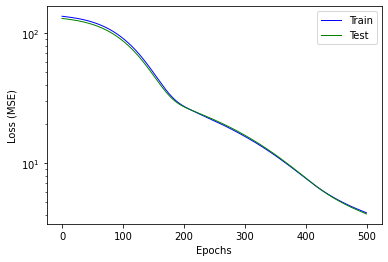

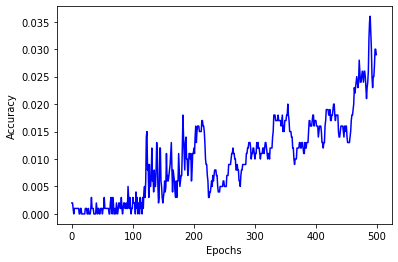

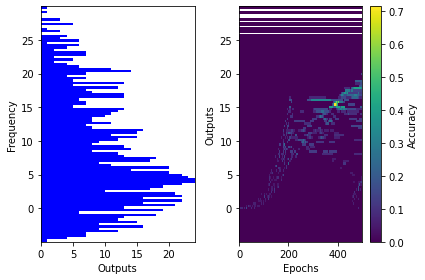

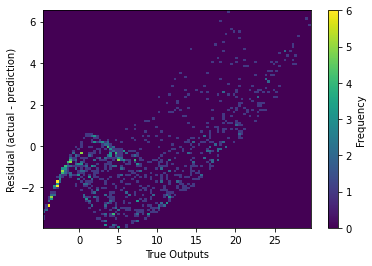

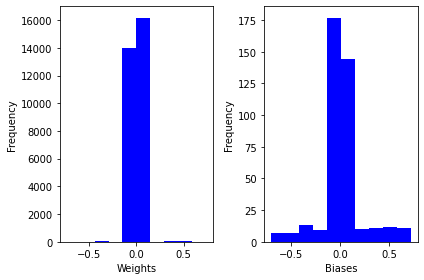

In [14]:
# Graphing
graphs = nnm.new_graphs()
nnm.graphing(graphs, graph_data, test_size, n_epochs, 100, 100)

In [17]:
# Show graphs
nnm.show_graphs(graphs)

In [19]:
# Save graphs
graphs['fig_loss'].savefig('loss.pdf')
graphs['fig_accu'].savefig('accu.pdf')
graphs['fig_accu_out'].savefig('accu_out.pdf')
graphs['fig_out_residual'].savefig('out_residual.pdf')
graphs['fig_histograms'].savefig('histograms.pdf')

In [6]:
# Analysis
param_list = [[1000, 2, 500, 1e-4, 0],[1000, 2, 500, 1e-5, 0],[1000, 2, 500, 1e-6, 0],[1000, 2, 500, 1e-7, 0],[1000, 2, 500, 1e-8, 0]] # [nodes, layers, epochs, learning rate, weight decay]
trials = 1 # The number of trials for each configuration
analysis_data = nnm.analyze(param_list, trials, inputs, outputs, test_inputs, test_outputs, batch_size)

Training done!
Training done!
Training done!
Training done!
Training done!


{'fig_analysis': <Figure size 432x288 with 1 Axes>,
 'ax_analysis': <matplotlib.axes._subplots.AxesSubplot at 0x2b638f7f4208>}

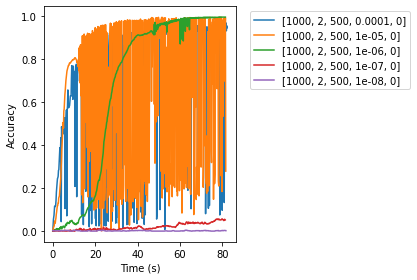

In [7]:
# Graphing
analysis_graphs = nnm.new_analysis_graphs()
nnm.analysis_graphing(analysis_graphs, analysis_data, param_list, trials)

In [8]:
analysis_graphs['fig_analysis'].savefig('analysis.pdf')

In [22]:
# Send data to be displayed
df = pd.DataFrame(data=analysis_data)

In [23]:
# Display analysis data
### Make graphs
print(df)

     nodes  layers  epochs      time  accuracy
0    100.0     1.0     0.0  0.024497     0.001
1    100.0     1.0     1.0  0.192594     0.002
2    100.0     1.0     2.0  0.347872     0.004
3    100.0     1.0     3.0  0.503090     0.008
4    100.0     1.0     4.0  0.664804     0.015
..     ...     ...     ...       ...       ...
445  100.0     1.0    45.0  7.133812     0.063
446  100.0     1.0    46.0  7.292924     0.070
447  100.0     1.0    47.0  7.449513     0.076
448  100.0     1.0    48.0  7.604756     0.079
449  100.0     1.0    49.0  7.766390     0.081

[450 rows x 5 columns]


In [17]:
# Uploads existing data and adds it to working dataset
# file_upload = read_csv("NN_Test_Data_1.csv")
# print(file_upload)
# df = df.append(file_upload)

In [24]:
# Saves run data as csv file
df.to_csv("NN_Test_Data_1.csv", index=False)